# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

### Additional infos about the data
Additional infos from the corresponding video: 
- "This is simulated data for the sake of testing the algorithms. Not simulated data for the sake of mimiking real people."
- "Some people might respond negatively"
- "The goal is to discover what the best offer is in there [...] on an induvidual personalized level"

### What to do?

The ultimate goal is to generate business value. When sending adds there are multiple factors.
There are costs:
- Creating offers costs money. So an offer with zero response is lost effort
    - None of the offers have zero response. We can compare their effectiveness against eachother
- Deploying offers probably is not expensive so it is not worth considering.
    - however we could figure out when it´s best to deploy offers
- Giving out rewards costs money. How much exactly e.g. a BOGO offer really costs the company only can be guessed since giving rewards of x$ sale value does cost the company less than x$. So we would have to make assumptions there. 
    - we could try to identify how much an offer increases spending. Therefore however we would need two groups. 
and there are benefits
- Offers increase customer spending and therefore revenue

->
- classify if offer gets accepted
- classify if negative effect - we need some kind of controll group. search for it
  - we could try to identify demographic groups with similar behaviour but left out offers

## What we will do
- explore the data and see what we actually CAN da
- create a ML model that can predict if the offer gets accepted or not
- depending on the data another we can use SVD. 
    - There we could split the time data in half and predict the user reactions based on their an others previous behaviour
    - use the already implemented model to deal with the cold start problem
    - Then we can compare the aproaches
- figure out a way to get information about when not to send offers
- the ultimative goal would be a model that figures out by how much an offer in or decreases spending

## expectation
- high income do not react as well on adds as lower income
- older demographics won´t react as well.
- there will be a lot of inactive users who do not react at all



# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1356]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Explore and clean data

In [1357]:
portfolio.head(15)
# we do have 3 different offer types. 
# - BOGO means By One Get One Free which is also why reward and difficulty match
# - informational only seems to be advertisement since there is no reward
# - discount is selfexplanatory. There however the difficulty VS reward seems a lot higher than BOGO

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [1358]:
# now the cleaning process ... 
# create index containing type so we do not have to deal with hashes
portfolio.sort_values(['offer_type', 'reward', 'difficulty'], inplace=True)
offer_short_name = []
offer_type_counts = {}
for offer_type in portfolio.offer_type:
    offer_type = offer_type[0:4]
    offer_count = 0
    if not offer_type in offer_type_counts:
        offer_type_counts[offer_type] = 0
    else:
        offer_type_counts[offer_type] +=1
    offer_short_name.append(offer_type + str(offer_type_counts[offer_type]))
offer_short_name
portfolio['offer_short_name'] = offer_short_name

In [1359]:
# as a final step let´s get the dummy variables
portfolio = portfolio.join(pd.get_dummies(portfolio.offer_type, dtype=np.int16))
portfolio = portfolio.join(pd.get_dummies(portfolio.channels.explode(), dtype=np.int16).sum(level=0))
portfolio.drop(columns = ['channels', 'offer_type'], inplace = True)

In [1360]:
portfolio.head(15)

,reward,difficulty,duration,id,offer_short_name,bogo,discount,informational,email,mobile,social,web
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo0,1,0,0,1,1,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo1,1,0,0,1,1,1,1
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo2,1,0,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo3,1,0,0,1,1,1,1
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,disc0,0,1,0,1,1,1,1
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,disc1,0,1,0,1,1,0,1
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,disc2,0,1,0,1,1,1,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,disc3,0,1,0,1,0,0,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,info0,0,0,1,1,1,0,1
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,info1,0,0,1,1,1,1,0


In [1361]:
# let´s have a look at the user profiles
profile.head(15)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [1362]:
# We can see that there missing gender age and income 
# 118 seems to be the default value for a missing age
profile.age.replace(118, np.NAN, inplace=True)
# let´s drop all data that has zero information about a customer. We do want to make predictions about
# populations. Having zero information about a customer should result in little benefit.
# Losing 12% of entries also is not substantial. In a later iteration one could make another decision and
# train on the "no data" case as a special case.
mask_no_data = profile.gender.isnull() & profile.age.isnull() & profile.income.isnull()
print("Amount of dropped data: " + str(profile[mask_no_data].shape[0]/profile.shape[0]*100) + "%")
profile.drop(profile[mask_no_data].index,inplace=True)
profile[profile.gender.isnull()].shape[0], \
    profile[profile.age.isnull()].shape[0], \
        profile[profile.income.isnull()].shape[0]
# There were only entries missing all entires. No entry with single entries so no further decisions.

Amount of dropped data: 12.794117647058822%


(0, 0, 0)

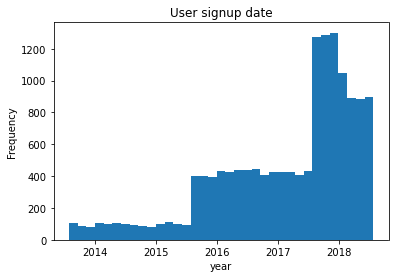

In [1363]:
profile.became_member_on = pd.to_datetime(profile.became_member_on,format='%Y%m%d')
plt.hist(profile.became_member_on, bins = 35);
plt.title("User signup date");
plt.xlabel("year");
plt.ylabel("Frequency");
# it seems like there are four major groups of memebers. 
# - The ones that joind before mid of 2015
# - The big group that got joined starting mid of 2015. This most likely is related 
#   to the introduciton of Mobile Order & Pay expanded in June 2015. 
#   See https://stories.starbucks.com/stories/2015/year-in-review-2015-starbucks-innovations/
# - The even bigger group that started joining end of 2017
# - the other big group that joined in 2018 (here it is debatable though if they stil belog to the previous group)
# this indicates some major add campaign was going on during these events these years
# So it could be possible that at least the user profiles could be sampled from real data and not simulated

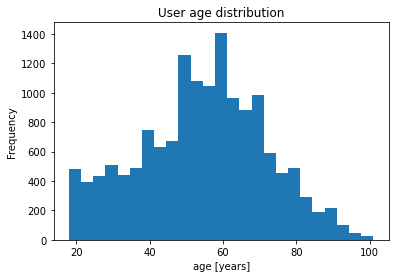

In [1364]:
plt.hist(profile.age, bins = 25);

plt.title("User age distribution");
plt.xlabel("age [years]");
plt.ylabel("Frequency");
# the age distribution looks surprising. I would have expected a lot younger customer base esp.
# since this data is from a mobile app

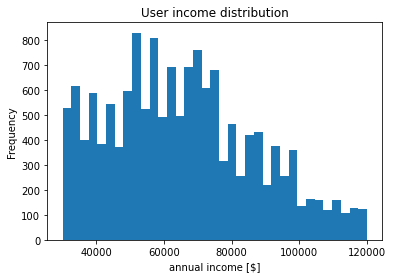

In [1365]:
plt.hist(profile.income, bins = 35);

plt.title("User income distribution");
plt.xlabel("annual income [$]");
plt.ylabel("Frequency");
# income looks reasonable and is kind of comparable to the average US household 
# income distribution http://theglitteringeye.com/u-s-income-distributiona-chart-to-contemplate/ . 
# However the expected highvalue at the max position of 120k is missing. It also seems that in average
# the more wealthy households go to Starbucks

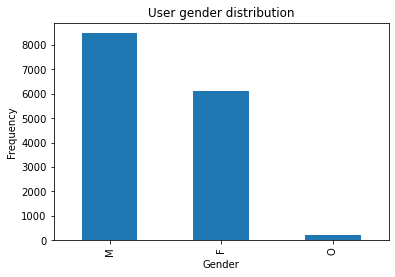

In [1366]:
profile.gender.value_counts().plot(kind = 'bar');
plt.title("User gender distribution");
plt.xlabel("Gender");
plt.ylabel("Frequency");

# also looks reasonable. interesting though that there there are more male than female customers

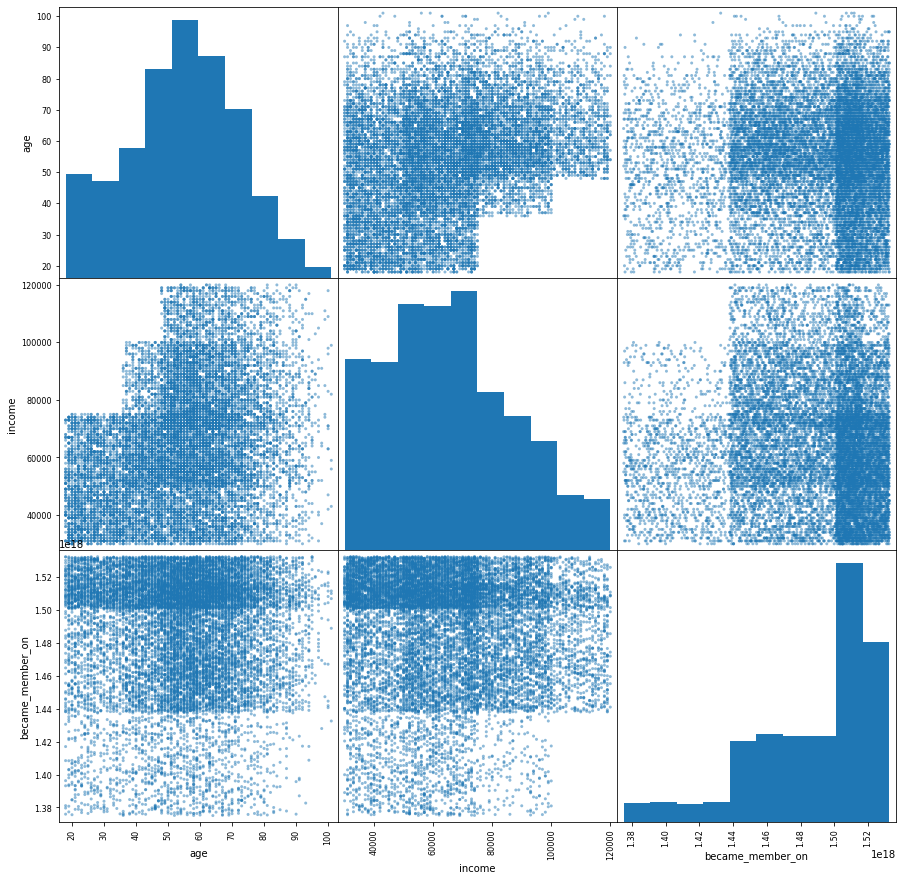

In [1367]:
# so now we can look at things combined everything:
profile_plt = profile.copy()
# unfortunatly pd scatter does not work for datetime so we do have deal with ints
profile_plt.became_member_on = profile_plt.became_member_on.astype(np.int64)
pd.plotting.scatter_matrix(profile_plt[['age','income', 'became_member_on']], figsize=(15,15));


interesting things to see are that
- there seems like an artificial limit for income. There is no customer till the age of 35 that makes more than 80k$ and noone below 50 years who makes more than 100k$.
- before mid of 2015 the max income you could enter at the signup process seems to be 100k because noone that signed up before has a higher number
We have to keep in mind that this is simulated data. Since this is simulated data weird effects also might come from the simulation

In [1368]:
transcript.head(15)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [1369]:
# Let´s clean the event data
# so we have data of all costomers that are related to interactions. That´s good :)
profile.id.isin(transcript.person).mean()
transcript.person.isin(profile.id).mean() 
# now we get rid of the events that concern customers we have no profile data
mask_no_data = ~transcript.person.isin(profile.id)
print("Amount of dropped data: " + str(transcript[mask_no_data].shape[0]/transcript.shape[0]*100) + "%")
transcript.drop(transcript[mask_no_data].index,inplace=True)

Amount of dropped data: 11.017374907840566%


In [1370]:
transcript = pd.concat([transcript.drop(['value'], axis=1), transcript.value.apply(pd.Series)], axis=1)
# we get rid of the dict and clean up the duplicated offer_id entry
transcript.offer_id.fillna(transcript['offer id'], inplace=True)
transcript.drop(columns=['offer id'],inplace=True)
# and create dummy variables for the event
transcript = transcript.join(pd.get_dummies(transcript.event, dtype=np.int16))
transcript.rename(columns={'offer completed': 'offer_completed', \
    'offer received' : 'offer_received', 'offer viewed' : 'offer_viewed'}, inplace=True)

In [1371]:
# now we can combine everything: 
profile.rename(columns={'id': 'person'}, inplace=True)
transcript = transcript.merge(profile, how='left', on='person')
portfolio.rename(columns={'id': 'offer_id', 'reward' : 'offer_reward'}, inplace=True)
transcript = transcript.merge(portfolio, how='left', on='offer_id')
rewards = transcript.query("event == 'offer completed'")[['reward','offer_reward']]

np.sum(rewards.reward != rewards.offer_reward)
# reward and offer reward match so we can drop the event reward
transcript.drop(columns=['reward'],inplace=True)

In [1372]:
transcript.head()

,person,event,time,amount,offer_id,offer_completed,offer_received,offer_viewed,transaction,gender,...,difficulty,duration,offer_short_name,bogo,discount,informational,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,F,...,5.0,7.0,bogo0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
1,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0,0,M,...,10.0,7.0,disc1,0.0,1.0,0.0,1.0,1.0,0.0,1.0
2,389bc3fa690240e798340f5a15918d5c,offer received,0,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0,M,...,5.0,5.0,bogo1,1.0,0.0,0.0,1.0,1.0,1.0,1.0
3,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,NaN,3f207df678b143eea3cee63160fa8bed,0,1,0,0,M,...,0.0,4.0,info0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
4,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,F,...,20.0,10.0,disc3,0.0,1.0,0.0,1.0,0.0,0.0,1.0


14825

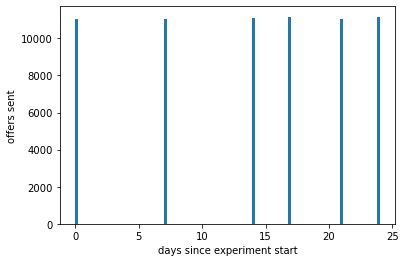

In [1373]:
# Let´s have a look at the recorded event data and try to understand the experiment
transcript.time.max()/24
# we do have roughly 30 days of event data. 30 days after signup for each customer? 30 days of events of all customers? 
# the assumption is that this is 30 continuous days of events since that makes most sense in terms of an experiment
plt.hist(transcript.query("event == 'offer received'").time/24,bins=100);

plt.xlabel("days since experiment start");
plt.ylabel("offers sent");
transcript.person.nunique()
# Within these 30 days at six different times offers get sent. The amount of offers sent each time roughly equals 
# the amount of users.

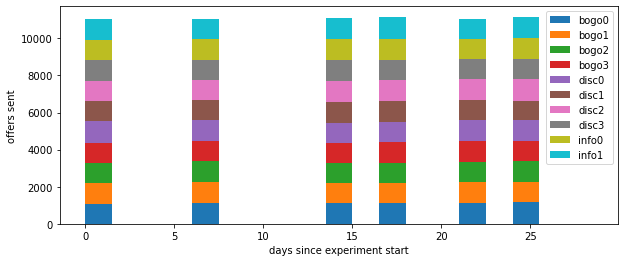

In [1374]:
# let´s figure out if there is a systematic when which offer was sent
ids = portfolio.offer_id.dropna().unique()
offers_sent = transcript.query("event == 'offer received'")
bins = np.arange(0,30,1.5)
stacked_offers = []
offer_names = []
for id in ids:
    vals = offers_sent.query("offer_id == @id").time/24
    stacked_offers.append(vals)
    offer_names.append(offers_sent.query("offer_id == @id").offer_short_name.dropna().unique()[0])
plt.figure(figsize=(10, 4))
plt.hist(stacked_offers, bins=bins,histtype='bar', stacked=True);
# TODO: create legend
plt.legend(offer_names,loc='upper right');
plt.xlabel("days since experiment start");
plt.ylabel("offers sent");
# all different offer types are sent out each time in roughly equal amounts to the customers

In [1375]:
offer_waves = (transcript.person.nunique() - transcript.query("event == 'offer received'").time.value_counts()\
    .sort_values())/transcript.person.nunique()*100
offer_waves2 = (transcript.person.nunique() - transcript.query("offer_received == 1").time.value_counts()\
    .sort_values())/transcript.person.nunique()*100
offer_waves
# about a quarter of users does get no offer each wave

0      25.645868
504    25.477234
168    25.389545
336    25.261383
408    24.964587
576    24.688027
Name: time, dtype: float64

C:\Users\patri\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,all offers,offers excluding informational
5,5173,2748.0
4,4362,4561.0
6,2663,675.0
3,2028,4164.0
2,532,2059.0
1,62,557.0
0,5,61.0


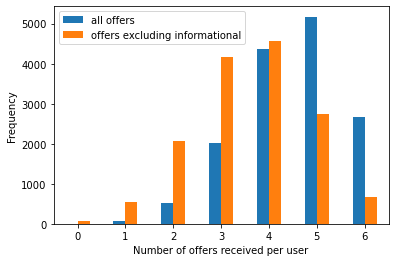

In [1376]:
# we want to know if there is an easy control group that never get´s any offer
plot_df = pd.DataFrame()
plot_df['all offers'] = transcript.groupby(['person']).sum()['offer_received'].value_counts()
plot_df['offers excluding informational'] = \
    transcript.query("informational == 0").groupby(['person']).sum()['offer_received'].value_counts()
plot_df.fillna(0, inplace = True)
# add customers that we filtered out again
plot_df['offers excluding informational'].loc[0] += \
    transcript.person.drop_duplicates().isin(transcript.query("informational == 0").person).value_counts().loc[False]
plot_df.sort_index().plot.bar(rot=0)
plt.xlabel("Number of offers received per user")
plt.ylabel("Frequency")
plot_df.head(10)
# The number of customers receiving no offer matches the expectation given the 25% of users
# are sampled randomly
# Looks like there is at least no easy control group for the whole experiment
# an option would be to not count informational offers as real offers but also then there is no
# control group with a sufficient size.

,wave 1,wave 2,wave 3,wave 4,wave 5,wave 6
0,3802.0,952.0,251.0,65.0,18.0,5
1,11023.0,5662.0,2180.0,738.0,231.0,62
2,0.0,8211.0,6198.0,3201.0,1407.0,532
3,0.0,0.0,6196.0,6136.0,3918.0,2028
4,0.0,0.0,0.0,4685.0,5718.0,4362
5,0.0,0.0,0.0,0.0,3533.0,5173
6,0.0,0.0,0.0,0.0,0.0,2663


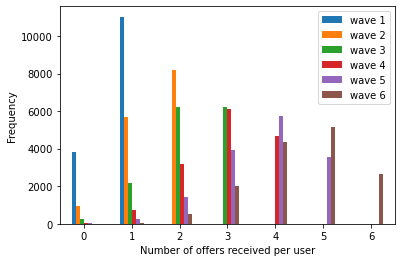

In [1377]:
wave_times = np.sort(offer_waves.index)
received_offers = []
labels = []
plot_df = pd.DataFrame(index=range(7))
wave_id = 1
for time in wave_times:
    customer_per_time = transcript.query("time < (@time+1)").groupby(['person']).sum()
    wave_name = "wave " + str(wave_id)
    wave_id += 1
    plot_df[wave_name] = customer_per_time['offer_received'].value_counts()
    plot_df.fillna(0, inplace = True)
    try:
        plot_df[wave_name].loc[0] += \
            transcript.person.drop_duplicates().isin(customer_per_time.index).value_counts().loc[False]
    except:
        pass

plot_df.sort_index().plot.bar(rot=0)
plt.xlabel("Number of offers received per user")
plt.ylabel("Frequency")
plot_df.head(10)

In [1378]:
# At least for the first wave we would have a big enough control group. one option would be to treat this first
# wave as an individual experiment and investigate this as an A/B test. Since there are 10 different offers tested at the same time
# each control group would around 400 data points.
# another option is the assumption in the data desciption:
# "for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the 
# offer for 7 days after receiving the advertisement."
# Since we are working with simulated data this is probably an asumption of the simulation as well. So we might not suffer from
# effects of previous offers treating the waves as individual experiments only with different historic data

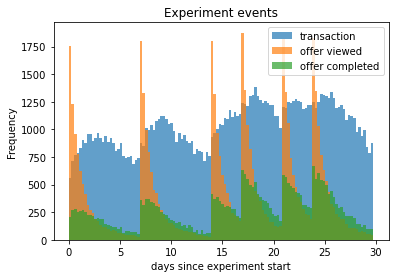

In [1379]:
num_bins = 120
transparancy = 0.7
events = ['transaction', 'offer viewed', 'offer completed']
for event in events:
    (transcript.query("event == @event").time/24).plot.hist(bins=num_bins, alpha = transparancy, label = event);
plt.title("Experiment events");
plt.legend(loc='upper right');
plt.xlabel("days since experiment start");
# it looks like the offers have impact on the user behaviour.

In [1380]:
# let´s investigate that in more detail by looking at the first wave
start_wave_2 = wave_times[1]
start_wave_3 = wave_times[2]
start_wave_4 = wave_times[3]
data_during_w1 = transcript.query("time < (@start_wave_2)")
data_during_w2 = transcript.query("time > (@start_wave_2-1) & time < (@start_wave_3)")
users_during_w1 = data_during_w1.groupby(['person']).sum()
users_during_w1

,time,amount,offer_completed,offer_received,offer_viewed,transaction,age,income,offer_reward,difficulty,duration,bogo,discount,informational,email,mobile,social,web
person,,,,,,,,,,,,,,,,,,
0011e0d4e6b944f998e987f904e8c1e5,138,13.49,0,1,1,1,120.0,171000.0,0.0,0.0,8.0,0.0,0.0,2.0,2.0,2.0,0.0,2.0
0020c2b971eb4e9188eac86d93036a77,402,98.33,1,1,1,4,413.0,630000.0,6.0,30.0,30.0,0.0,3.0,0.0,3.0,3.0,3.0,3.0
0020ccbbb6d84e358d3414a3ff76cffd,42,16.27,0,0,0,1,24.0,60000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003d66b6608740288d6cc97a6903f4f0,174,2.51,0,1,1,2,104.0,292000.0,0.0,0.0,6.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0
00426fe3ffde4c6b9cb9ad6d077a13ea,498,30.92,0,1,1,7,171.0,585000.0,0.0,0.0,6.0,0.0,0.0,2.0,2.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,198,81.41,1,1,1,4,483.0,581000.0,6.0,30.0,30.0,0.0,3.0,0.0,3.0,3.0,3.0,3.0
fff7576017104bcc8677a8d63322b5e1,60,5.55,0,1,1,1,213.0,219000.0,4.0,20.0,20.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0
fff8957ea8b240a6b5e634b6ee8eafcf,18,0.64,0,0,0,1,71.0,56000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1381]:
data_during_wave = data_during_w1
person = data_during_wave.loc[112].person
person_events = data_during_wave.query("person == @person")
person_events


,person,event,time,amount,offer_id,offer_completed,offer_received,offer_viewed,transaction,gender,...,difficulty,duration,offer_short_name,bogo,discount,informational,email,mobile,social,web
112,348bdc19d65f49b8b98f72c59e64cd89,offer received,0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,0,1,0,0,F,...,10.0,7.0,bogo2,1.0,0.0,0.0,1.0,1.0,1.0,0.0
15780,348bdc19d65f49b8b98f72c59e64cd89,offer viewed,12,NaN,ae264e3637204a6fb9bb56bc8210ddfd,0,0,1,0,F,...,10.0,7.0,bogo2,1.0,0.0,0.0,1.0,1.0,1.0,0.0
32719,348bdc19d65f49b8b98f72c59e64cd89,transaction,78,11.80,NaN,0,0,0,1,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32720,348bdc19d65f49b8b98f72c59e64cd89,offer completed,78,NaN,ae264e3637204a6fb9bb56bc8210ddfd,1,0,0,0,F,...,10.0,7.0,bogo2,1.0,0.0,0.0,1.0,1.0,1.0,0.0
40416,348bdc19d65f49b8b98f72c59e64cd89,transaction,120,22.38,NaN,0,0,0,1,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44076,348bdc19d65f49b8b98f72c59e64cd89,transaction,144,28.20,NaN,0,0,0,1,F,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1470]:
def plot_confidence_spending_change_by_offer(data_during_wave, all_user_ids = transcript.person.dropna().unique()):
    """
    Plots effects of different offers on the mean user spending by comparing it to the control group that does
    not recieve any offer. For generating a confidence interval bootstrapping is used.

    Args:
        data_during_wave: dataframe containing user events during one offer wave
        all_user_ids: all ids. necessary because there might be persons without events in the event data
    """
    # null hypothesis H0: receiving offers does not increase the average spending
    # H1 is that it increases spending
    # we can use bootstrapping to get a confidence interval of this hypothesis. Lets do that for all types
    offers = data_during_wave.offer_short_name.dropna().sort_values().unique()
    user_data = data_during_wave.groupby(['person']).sum().fillna(0)[['offer_received', 'amount','transaction']].copy()
    #user_data.amount.fillna(0,inplace = True)
    nrows=4
    ncols=3
    row = 0
    col = 0
    fig, axes = plt.subplots(nrows, ncols,figsize=(20,20))
    fig.tight_layout(h_pad=4, w_pad=4)
    fig.canvas.set_window_title('Influence of offer on spending')
    for offer in offers:
        diffs = []
        ids_got_offer = data_during_wave.query("(event == 'offer received')&(offer_short_name == @offer)").person.drop_duplicates()
        ids_controll = data_during_wave.query("(event == 'offer received')&(offer_short_name == @offer)").person.drop_duplicates()
        for _ in range(1000):
            bootsamp = user_data.sample(user_data.shape[0], replace = True)
            nooffer_mean = bootsamp.query("offer_received == 0").transaction.mean()
            offer_mean = bootsamp.query("index in @ids_offer").transaction.mean()
            diffs.append(offer_mean - nooffer_mean)
        
        plt.sca(axes[row,col])
        if col +1 >= ncols:
            col = 0
            row +=1
        else:
            col +=1
        
        plt.title(offer + " offer")
        diff_experiment = user_data.query("index in @ids_got_offer").transaction.mean() - \
            user_data.query("offer_received == 0").transaction.mean()
        plt.axvline(diff_experiment, color = 'black',label = "experiment");
        plt.hist(diffs,bins=40)
        ci_interval = 95
        # H1 is one tailed so we can cut off 5% for the 95% confidence interval
        plt.axvline(np.mean(diffs), color = 'grey',label = "mean");
        plt.axvline(np.percentile(diffs, 100 - ci_interval), color = 'red',label = str(ci_interval) + "% one-tailed CI");
        plt.legend(loc='upper right');
        plt.xlabel("Mean increase in sales per user [$]")
        plt.ylabel("Frequency")
    axes[3,1].axis('off')
    axes[3,2].axis('off')

array([  0, 168, 336, 408, 504, 576], dtype=int64)

In [1477]:
def get_offer_wave_events(transcript):
    offer_wave_times = np.sort(transcript.query("event == 'offer received'").time.value_counts().index)
    data_during_waves = []
    transcript_copy = transcript.copy()
    transcript_copy.amount.fillna(0,inplace=True)
    for i_wave in range(6):
        start_time = offer_wave_times[i_wave] -1
        end_time = 10000
        if i_wave < 5:
            end_time = offer_wave_times[i_wave + 1] - 24
        data_during_waves.append(transcript.query("time > @start_time & time <@end_time"))
    return data_during_waves

data_during_waves = get_offer_wave_events(transcript)

14825
(12904, 18)
1    11023
0     1881
Name: offer_received, dtype: int64
14825
(13375, 18)
1    11061
0     2314
Name: offer_received, dtype: int64
14825
(12187, 18)
1    11080
0     1107
Name: offer_received, dtype: int64
14825
(13172, 18)
1    11124
0     2048
Name: offer_received, dtype: int64
14825
(12608, 18)
1    11048
0     1560
Name: offer_received, dtype: int64
14825
(13920, 18)
1    11165
0     2755
Name: offer_received, dtype: int64


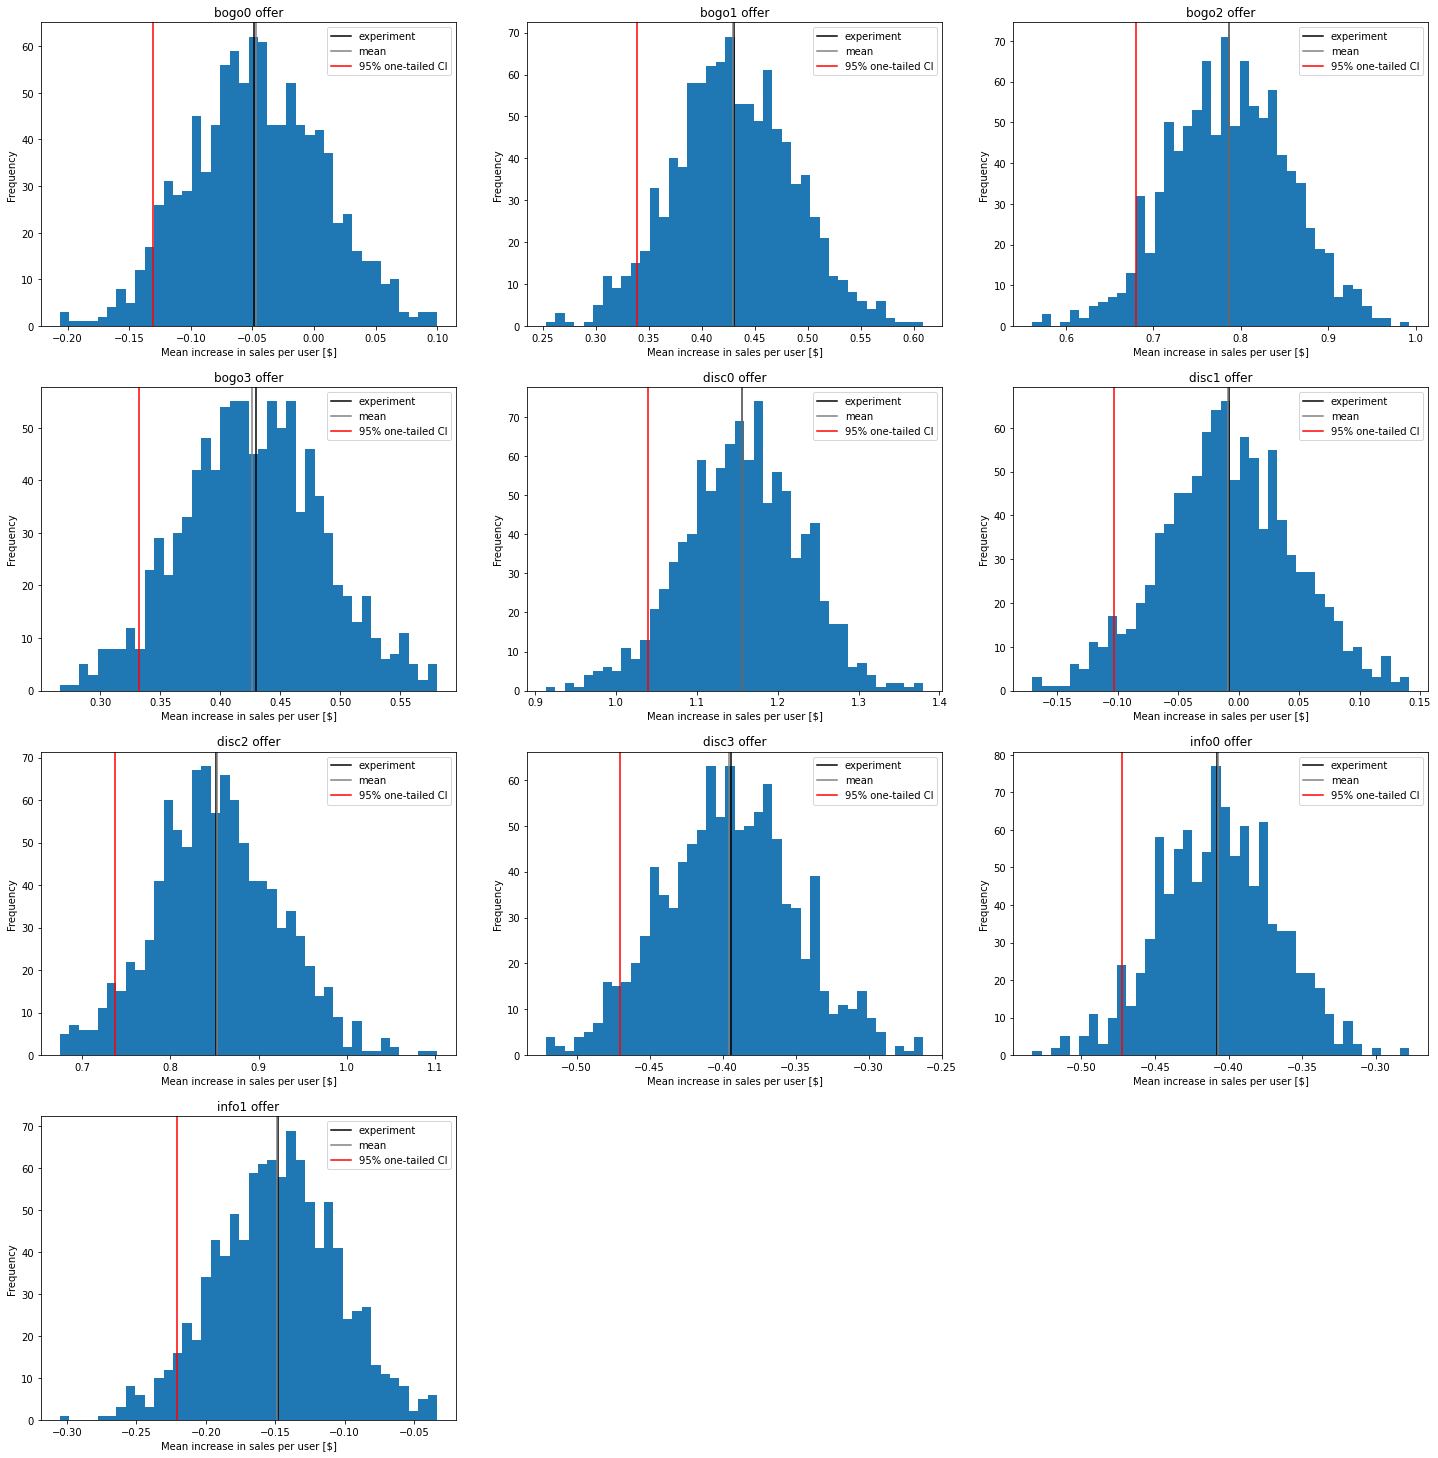

In [1468]:
plot_confidence_spending_change_by_offer(data_during_w1)
# we observe a statistical significant increase in customer spending. An increase of >1$ per week also seems like a practical significant
# result

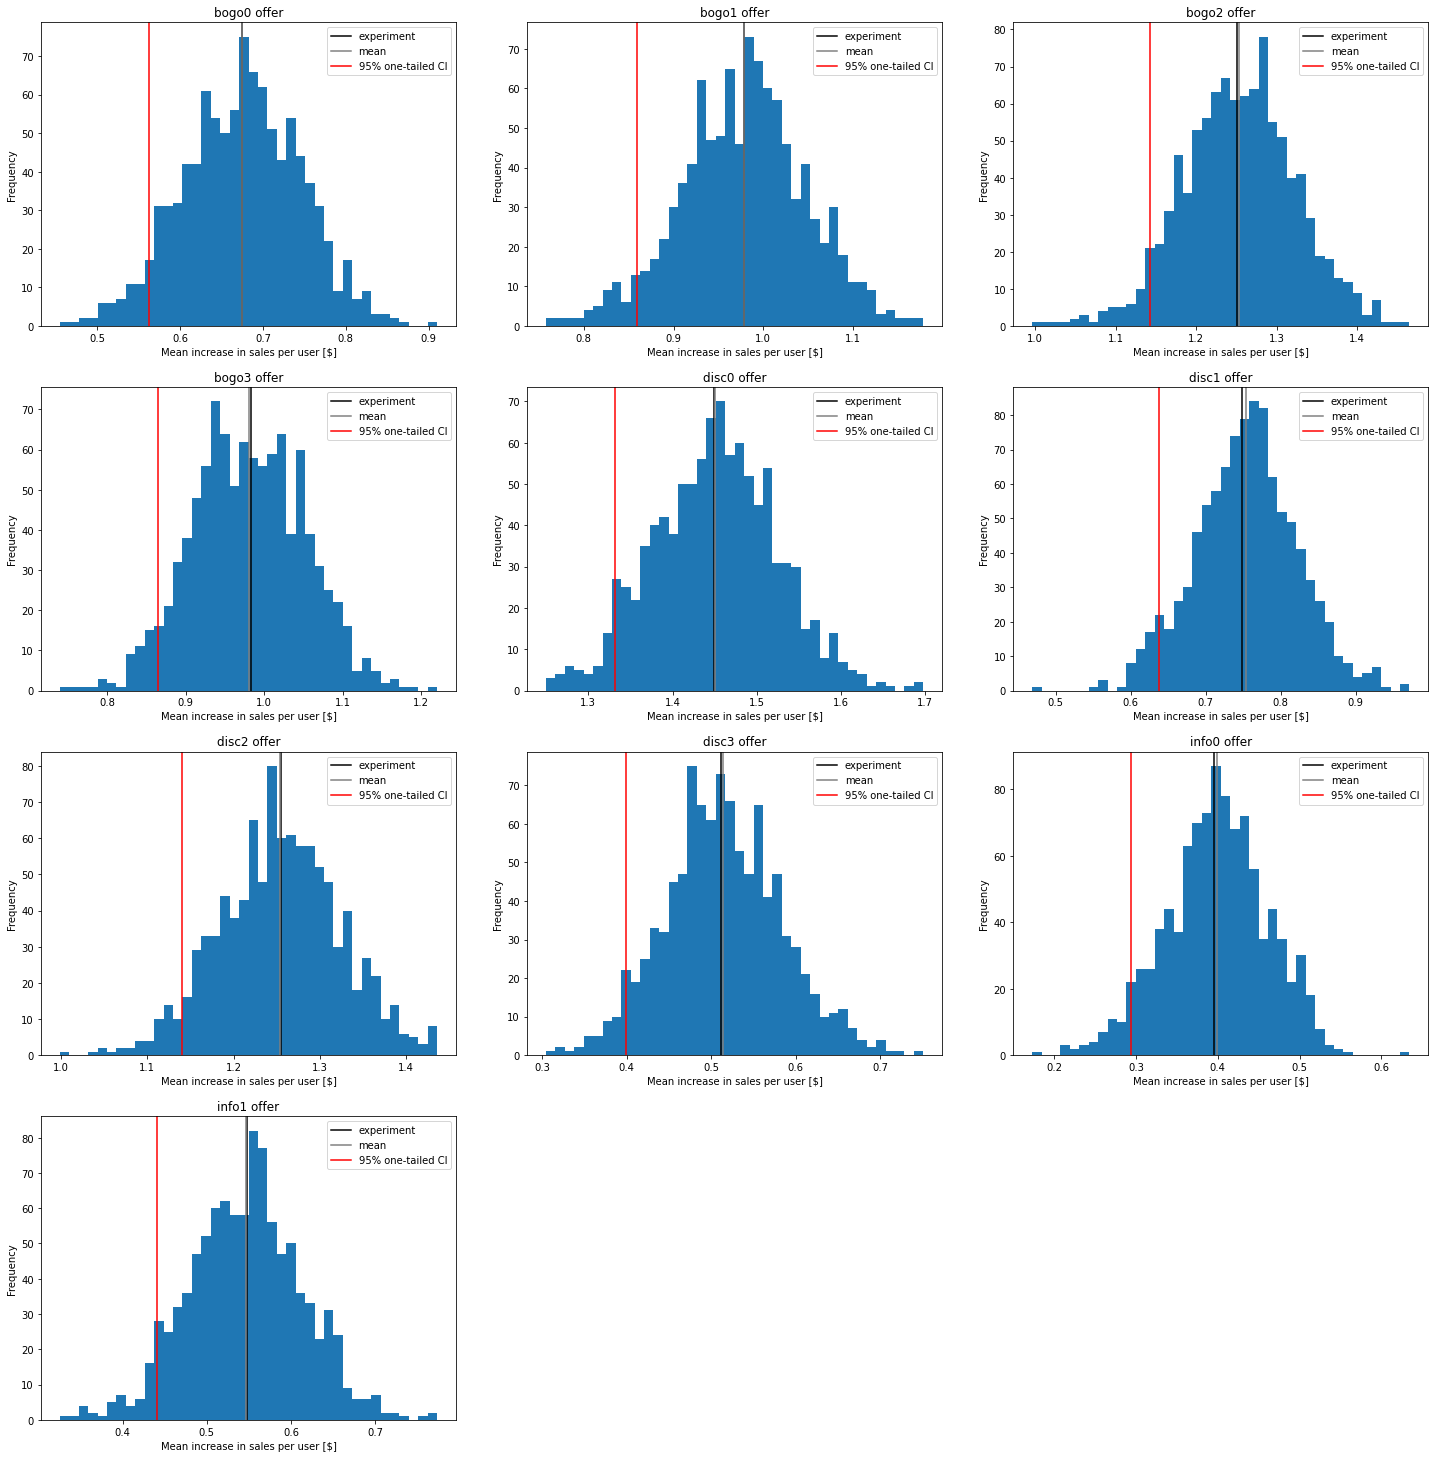

In [1412]:
plot_confidence_spending_change_by_offer(data_during_w6)

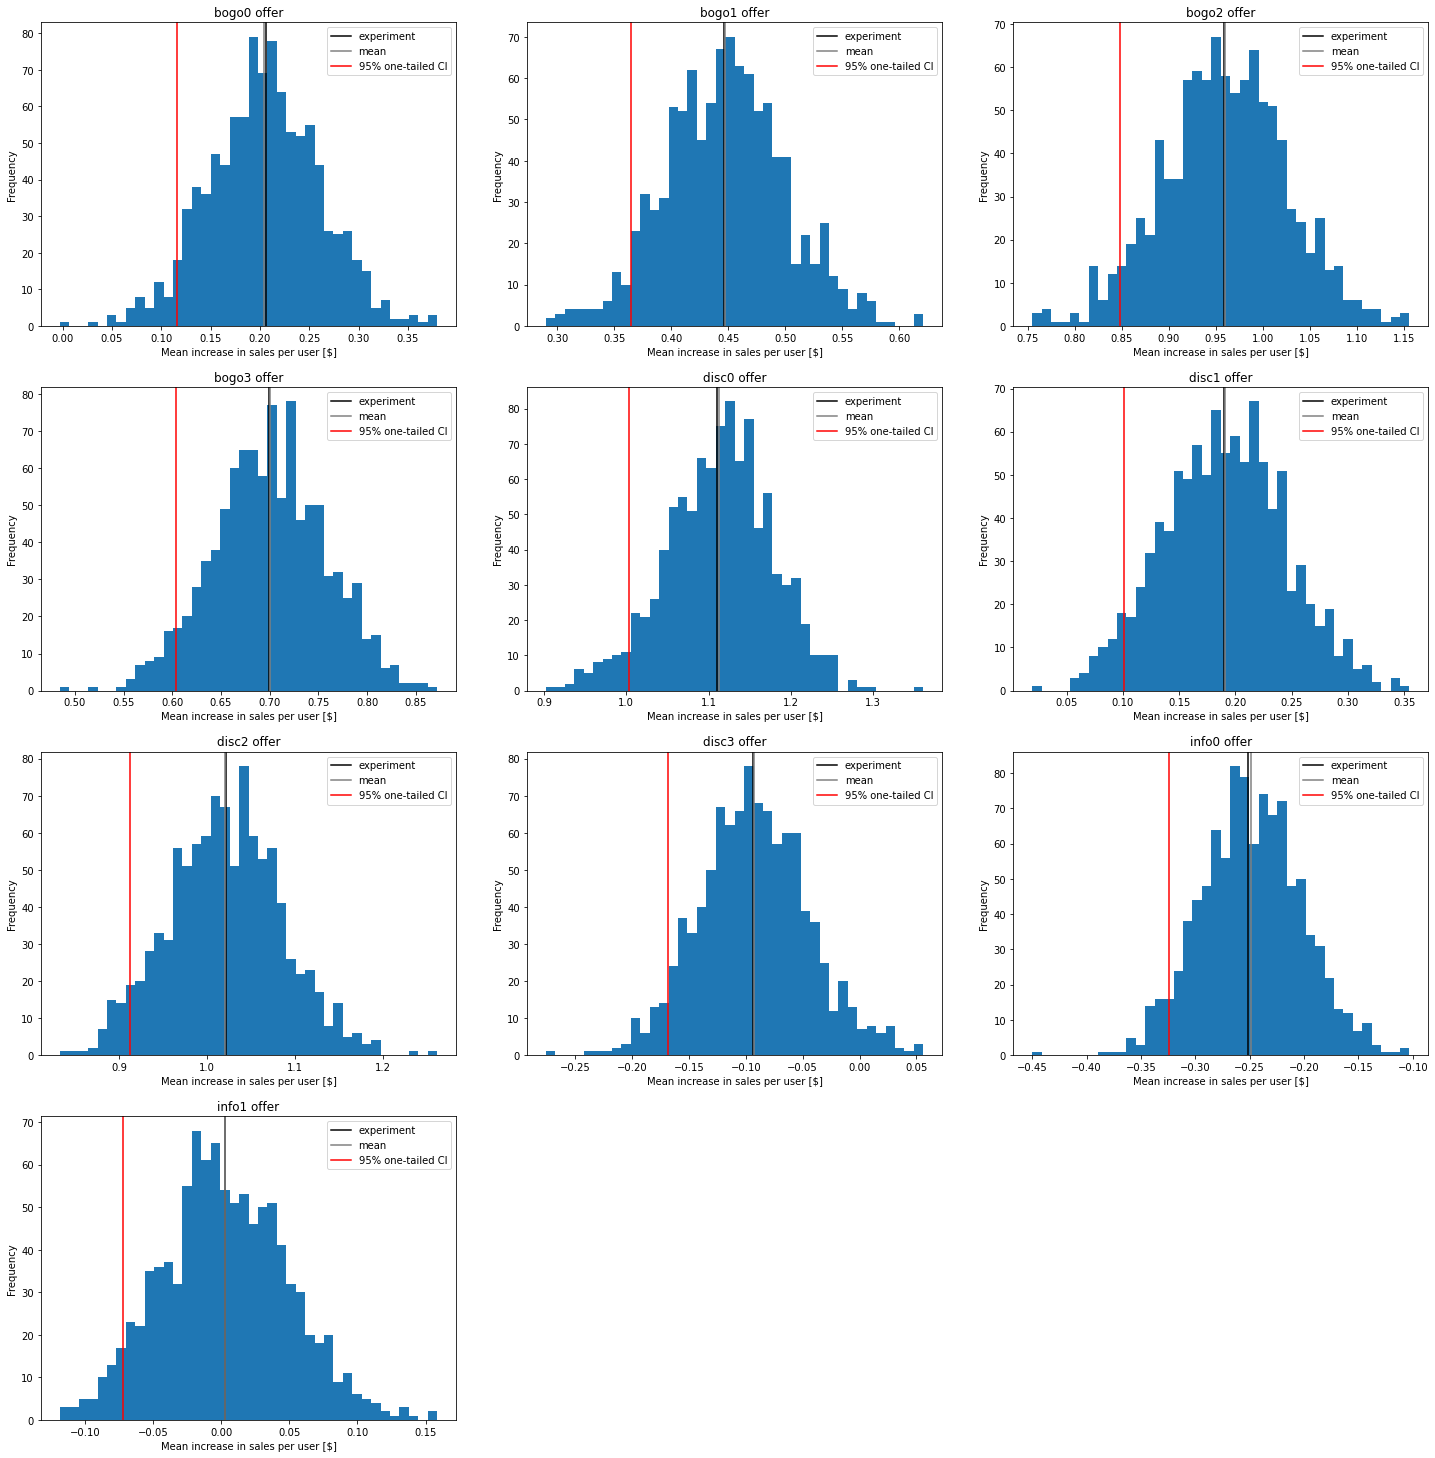

In [1403]:
plot_confidence_spending_change_by_offer(data_during_w2)

In [1384]:
users_during_w1.query("offer_received == 0").amount.mean(),\
    users_during_w1.query("offer_received == 1 & discount > 0").amount.mean(), \
        users_during_w1.query("offer_received == 1 & bogo > 0").amount.mean(), \
        users_during_w1.query("offer_received == 1 & informational > 0").amount.mean(),\
users_during_w1.query("offer_received == 0").amount.shape,\
    users_during_w1.query("offer_received == 1 & discount > 0").amount.shape, \
        users_during_w1.query("offer_received == 1 & bogo > 0").amount.shape, \
        users_during_w1.query("offer_received == 1 & informational > 0").amount.shape,

(21.954216634429397,
 28.094673107166894,
 26.055958419008405,
 16.332870159453307,
 (2068,),
 (4451,),
 (4377,),
 (2195,))

In [1523]:
# what we want to generate:
# id = user
# wave = 1-6
# - offerName (offerName, NaN == control)
# - viewed
# - completed
# - sum spent
# - no of transactions
wave_data = get_offer_wave_events(transcript)
user_event_data = pd.DataFrame()
user_event_data['person'] = transcript.person.dropna().unique()
for i_wave in range(6):
    wave = wave_data[i_wave]
    # let´s get the offers
    offer_type = wave.query("(event == 'offer received')")[['offer_short_name','person']]
    offer_type.rename(columns ={'offer_short_name' : 'w'+str(i_wave+1) +'_' + 'offer'},inplace = True)
    user_event_data = user_event_data.merge(offer_type, left_on='person', right_on='person',how='left').fillna('control')
    # let´s grab the summed data
    user_data = wave.groupby('person').sum()[['amount','transaction','offer_completed','offer_received','offer_viewed']]
    user_data.columns = 'w'+str(i_wave+1) +'_' + user_data.columns.values
    user_event_data = user_event_data.merge(user_data, left_on='person', right_on='person',how='left').fillna(0)
    
user_event_data

,person,w1_offer,w1_amount,w1_transaction,w1_offer_completed,w1_offer_received,w1_offer_viewed,w2_offer,w2_amount,w2_transaction,...,w5_transaction,w5_offer_completed,w5_offer_received,w5_offer_viewed,w6_offer,w6_amount,w6_transaction,w6_offer_completed,w6_offer_received,w6_offer_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,bogo0,19.89,1.0,1.0,1.0,1.0,info1,49.39,2.0,...,2.0,2.0,1.0,0.0,control,0.00,0.0,0.0,0.0,1.0
1,e2127556f4f64592b11af22de27a7932,disc1,0.00,0.0,0.0,1.0,1.0,control,39.31,2.0,...,1.0,2.0,1.0,1.0,control,0.00,0.0,0.0,0.0,0.0
2,389bc3fa690240e798340f5a15918d5c,bogo1,9.54,1.0,1.0,1.0,1.0,bogo0,0.00,0.0,...,0.0,0.0,1.0,1.0,disc0,11.26,1.0,2.0,1.0,1.0
3,2eeac8d8feae4a8cad5a6af0499a211d,info0,0.00,0.0,0.0,1.0,0.0,disc2,2.32,1.0,...,0.0,0.0,0.0,0.0,control,0.00,0.0,0.0,0.0,0.0
4,aa4862eba776480b8bb9c68455b8c2e1,disc3,0.00,0.0,0.0,1.0,1.0,bogo3,12.33,1.0,...,1.0,0.0,0.0,0.0,bogo1,12.56,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14820,47683732768a4f7db7abb710ca22e66e,control,0.00,0.0,0.0,0.0,0.0,control,0.00,0.0,...,0.0,0.0,1.0,1.0,bogo2,7.10,1.0,0.0,1.0,1.0
14821,3873fe915496482eb589fa316ae7b0db,control,0.00,0.0,0.0,0.0,0.0,control,0.00,0.0,...,1.0,0.0,1.0,1.0,bogo1,3.86,2.0,0.0,1.0,1.0
14822,8578196a074a4f328976e334fa9383a3,control,0.00,0.0,0.0,0.0,0.0,control,0.00,0.0,...,0.0,0.0,1.0,1.0,disc1,4.62,1.0,0.0,1.0,0.0
14823,9fcbff4f8d7241faa4ab8a9d19c8a812,control,0.00,0.0,0.0,0.0,0.0,control,0.00,0.0,...,0.0,0.0,1.0,1.0,bogo3,0.00,0.0,0.0,1.0,1.0


In [ ]:
def plot_confidence_spending_change_by_offer(user_event_data, wave):
    """
    Plots effects of different offers on the mean user spending by comparing it to the control group that does
    not recieve any offer. For generating a confidence interval bootstrapping is used.

    Args:
        data_during_wave: dataframe containing user events during one offer wave
        all_user_ids: all ids. necessary because there might be persons without events in the event data
    """
    # null hypothesis H0: receiving offers does not increase the average spending
    # H1 is that it increases spending
    # we can use bootstrapping to get a confidence interval of this hypothesis. Lets do that for all types
    wave_prefix = 'w' + str(wave) + '_'
    field_name_transaction = wave_prefix + 'transaction'
    field_name_offer = wave_prefix + 'offer'
    offers = np.sort(user_event_data[wave_prefix+'offer'].unique())
    offers = np.delete(offers, np.argwhere(offers == 'control'))
    
    nrows=4
    ncols=3
    row = 0
    col = 0
    fig, axes = plt.subplots(nrows, ncols,figsize=(20,20))
    fig.tight_layout(h_pad=4, w_pad=4)
    fig.canvas.set_window_title('Influence of offer on spending')
    for offer in offers:
        diffs = []
        red_user_event_data = user_event_data[[field_name_offer,field_name_transaction]].copy()
        for _ in range(1000):
            bootsamp = red_user_event_data.sample(red_user_event_data.shape[0], replace = True)
            nooffer_mean = bootsamp.query(field_name_offer +" == 'control'")[field_name_transaction].mean()
            offer_mean = bootsamp.query(field_name_offer +" == @offer")[field_name_transaction].mean()
            diffs.append(offer_mean - nooffer_mean)
        
        plt.sca(axes[row,col])
        if col +1 >= ncols:
            col = 0
            row +=1
        else:
            col +=1
        
        plt.title(offer + " offer")
        diff_experiment = user_event_data.query(field_name_offer +" == @offer")[field_name_transaction].mean() - \
            user_event_data.query(field_name_offer +" == 'control'")[field_name_transaction].mean()
        plt.axvline(diff_experiment, color = 'black',label = "experiment");
        plt.hist(diffs,bins=40)
        ci_interval = 95
        # H1 is one tailed so we can cut off 5% for the 95% confidence interval
        plt.axvline(np.mean(diffs), color = 'grey',label = "mean");
        plt.axvline(np.percentile(diffs, 100 - ci_interval), color = 'red',label = str(ci_interval) + "% one-tailed CI");
        plt.legend(loc='upper right');
        plt.xlabel("Mean increase in sales per user [$]")
        plt.ylabel("Frequency")
    axes[3,1].axis('off')
    axes[3,2].axis('off')

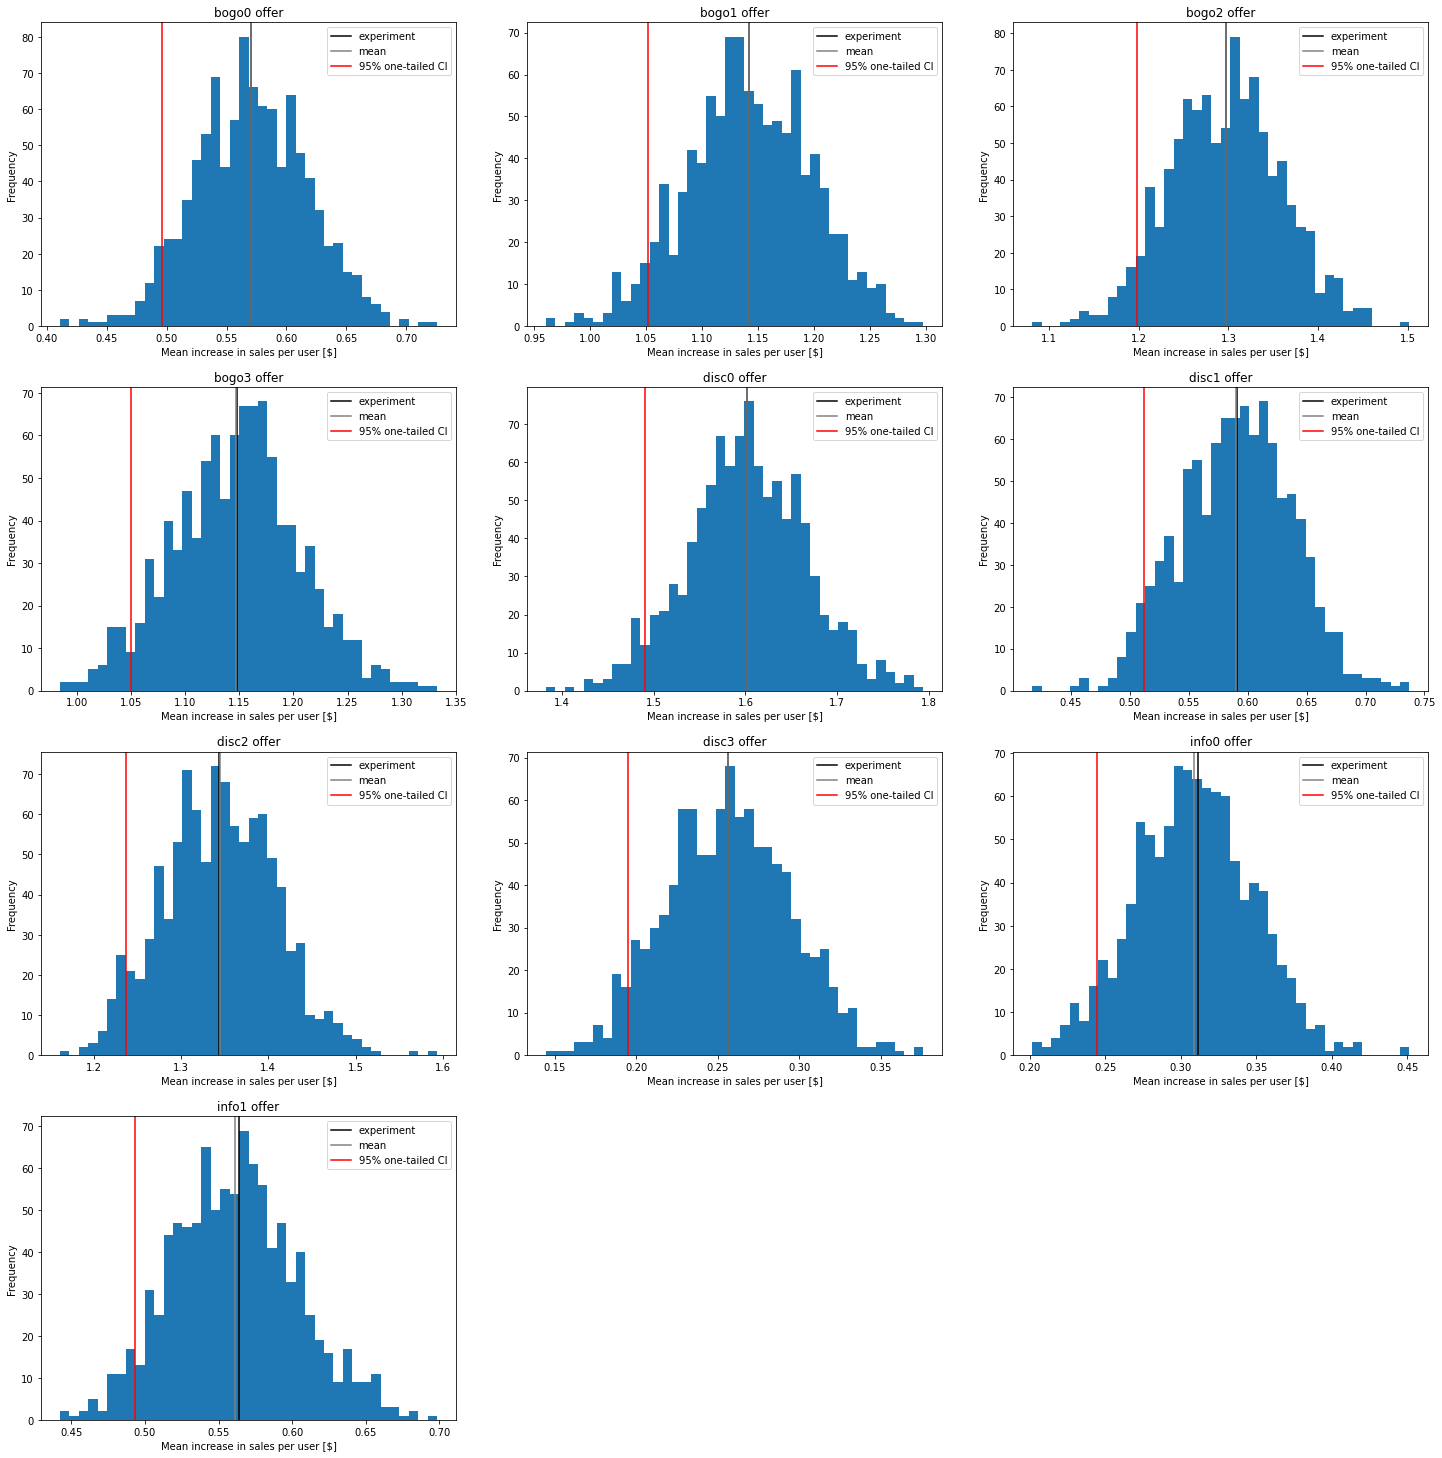

In [1551]:

plot_confidence_spending_change_by_offer(user_event_data, 1)

In [1552]:
plot_confidence_spending_change_by_offer(user_event_data, 2)

In [1386]:
# So we now do understand what happens:
# - all offers are sent in roughly equal amounts to customers in 6 waves
# - 25% of customers do not get an offer per wave
# - the assumption is that which offer is sent to which user is done by random sampling
#   this hypothesis could be confirmed investigating it´s statistical significance

In [1387]:
# TODOS
# create labels:
# - state - person atts, historic atts
# - different waves - which offer recieved. How much total spent.
# - goal1: completed/not_completed/completed_without_viewing
# - goal2: increased spending per day/decreased spending per day
# see which demographic reacts best to which offer in terms of completing & increase spending

## Takeaways

- a big challenge was to understand the experiment itself. Most of the informations about the experiment had to be reverse engineered from the data. Only with understanding the experiment it was possible to figure out what business value we can generate from the data.